<a href="https://colab.research.google.com/github/moexalgo/moexalgo.github.io/blob/main/examples/library-examples/websocket/multiple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install moexalgo
#!pip install matplotlib

import pandas as pd
import matplotlib.pyplot as plt
from moexalgo.beta import issplus
import asyncio

# Данные для входа
ws_login = 'ваш_логин'
ws_passcode = 'ваш_пароль'

tickers = ['SBER', 'GAZP', 'LKOH']

async def websocket_multiple_orderbooks():
    url = 'wss://iss.moex.com/infocx/v3/websocket'
    credentials = issplus.Credentials('passport', ws_login, ws_passcode)
    
    current_data = {}
    
    async with issplus.connect(url, credentials) as client:
        # Подписываемся на все инструменты, заполняя структуру вида ticker:subscription 
        subscriptions = {}
        for ticker in tickers:
            destination = 'MXSE.orderbooks'
            selector = f'TICKER="MXSE.TQBR.{ticker}"'
            subscription = await client.subscribe(destination, selector)
            subscriptions[ticker] = subscription
            print(f"Подписка {ticker}: {subscription.id}")
            await asyncio.sleep(0.1)
        
        print()
        
        # Метод для обработки каждой отдельной подписки
        async def process_ticker(ticker, subscription):
            async for data in subscription:
                df = pd.DataFrame(data['data'], columns=data['columns'])
                df['price'] = df['PRICE'].apply(lambda x: x[0])
                df['qty'] = df['QUANTITY']
                
                current_data[ticker] = df
                
                bids = df[df['BUYSELL'] == 'B'].copy()
                asks = df[df['BUYSELL'] == 'S'].copy()
                
                print(f"Снэпшот {ticker}")
                print(f"Спред: {asks['price'].min():.2f} - {bids['price'].max():.2f}")
                
                print("\nBID (покупка)          ASK (продажа)")
                for i in range(min(5, len(bids))):
                    bid_price = bids.iloc[-(i+1)]['price']
                    bid_qty = bids.iloc[-(i+1)]['qty']
                    ask_price = asks.iloc[i]['price']
                    ask_qty = asks.iloc[i]['qty']
                    print(f"{bid_price:>7.2f} x {bid_qty:<6}       {ask_price:>7.2f} x {ask_qty:<6}")
                print()
                
                # Остановка после первого снэпшота (для примера)
                break
        
        # Параллельная обработка всех подписок через asyncio.gather
        tasks = [process_ticker(ticker, sub) for ticker, sub in subscriptions.items()]
        await asyncio.gather(*tasks)
    
    return current_data

orderbook_data = await websocket_multiple_orderbooks()

Подписка SBER: dd58e89d-a0be-494b-a795-e08f3be3e1d4
Подписка GAZP: 567e2858-fc1d-4b84-bbad-fa34e8e6ebc4
Подписка LKOH: 0d49a71b-c844-486b-bfff-d8a893f168cc

Снэпшот SBER
Спред: 306.45 - 306.42

BID (покупка)          ASK (продажа)
 306.42 x 33            306.45 x 3051  
 306.41 x 327           306.46 x 800   
 306.40 x 605           306.47 x 2500  
 306.39 x 1642          306.48 x 3959  
 306.38 x 827           306.49 x 3059  

Снэпшот GAZP
Спред: 126.42 - 126.41

BID (покупка)          ASK (продажа)
 126.41 x 53            126.42 x 434   
 126.40 x 421           126.43 x 1332  
 126.39 x 247           126.44 x 1610  
 126.38 x 6552          126.45 x 2195  
 126.37 x 565           126.46 x 1760  

Снэпшот LKOH
Спред: 5398.00 - 5397.00

BID (покупка)          ASK (продажа)
5397.00 x 81           5398.00 x 376   
5396.50 x 97           5398.50 x 182   
5396.00 x 98           5399.00 x 208   
5395.50 x 236          5399.50 x 281   
5395.00 x 1013         5400.00 x 483   



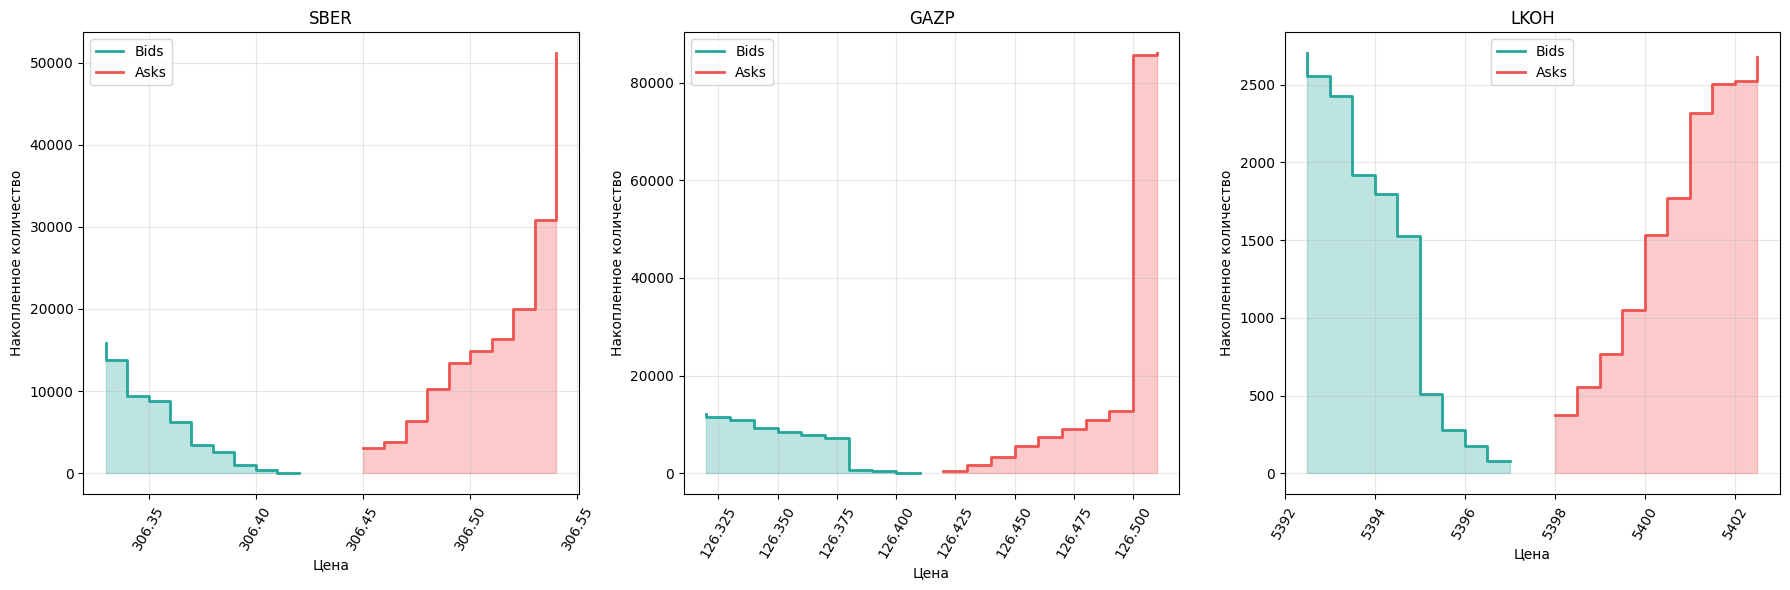

In [21]:
fig, axes = plt.subplots(1, len(tickers), figsize=(18, 6))

for idx, ticker in enumerate(tickers):
    if ticker in orderbook_data:
        df = orderbook_data[ticker]
        
        bids = df[df['BUYSELL'] == 'B'].sort_values('price', ascending=False)
        asks = df[df['BUYSELL'] == 'S'].sort_values('price')
        
        bids['cumqty'] = bids['qty'].cumsum()
        asks['cumqty'] = asks['qty'].cumsum()
        
        ax = axes[idx]
        
        ax.step(bids['price'], bids['cumqty'], where='post', color='#26a69a', linewidth=2, label='Bids')
        ax.step(asks['price'], asks['cumqty'], where='post', color='#ef5350', linewidth=2, label='Asks')
        
        ax.fill_between(bids['price'], bids['cumqty'], step='post', color='#26a69a', alpha=0.3)
        ax.fill_between(asks['price'], asks['cumqty'], step='post', color='#ef5350', alpha=0.3)
        
        ax.set_xlabel('Цена')
        ax.set_ylabel('Накопленное количество')
        ax.set_title(f'{ticker}')
        ax.legend()
        ax.grid(alpha=0.3)
        ax.tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.show()